In [300]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from time import time
from operator import itemgetter
import string
import collections
from pprint import pprint
from __future__ import division

%matplotlib inline

In [301]:
csv_IpadTrain = 'eBayiPadTrain.csv'
csv_IpadTest = 'eBayiPadTest.csv'

rawTrainNew = pd.read_csv(csv_IpadTrain)
rawTestNew = pd.read_csv(csv_IpadTest)

In [302]:
def learning_curve_plot(model,X,y):
    from sklearn.learning_curve import learning_curve

    # assume classifier and training data is prepared...

    #log = LogisticRegression()

    train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=10, n_jobs=1, train_sizes=np.linspace(.1, 1., 10), verbose=0)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("RandomForestClassifier")
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.ylim((0.6, 1.01))
    plt.gca().invert_yaxis()
    plt.grid()

    # Plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Test score")

###Bag of Words(Setting it up)

In [303]:
conditionrep = {'New other (see details)' : 'New',
               'For parts or not working' : 'Buy for Parts',
               'Seller refurbished' : 'Used'}
rawTrainNew['condition'] = rawTrainNew['condition'].replace(conditionrep)
rawTestNew['condition'] = rawTestNew['condition'].replace(conditionrep)

In [304]:
rawTrainNew['description'] = rawTrainNew['description'].fillna('NA')
rawTestNew['description'] = rawTestNew['description'].fillna('NA')

In [305]:
rawTrainNew['productline'] = rawTrainNew['productline'].replace({'iPad 5' : 'iPad Air'})

In [306]:
rawTrainNew['description'] = rawTrainNew['description'] +' ' + rawTrainNew['condition'] +' '+rawTrainNew['carrier']+ ' ' +rawTrainNew['color'] + ' ' +rawTrainNew['storage'] + ' ' + rawTrainNew['productline']
rawTestNew['description'] = rawTestNew['description'] +' ' + rawTestNew['condition'] +' '+rawTestNew['carrier']+ ' ' +rawTestNew['color'] + ' ' +rawTestNew['storage'] + ' ' + rawTestNew['productline']

In [307]:
rawTrainNew.iloc[2][0]

'NA Used None White 16 iPad 4'

In [308]:
corpus = rawTrainNew['description'].append(rawTestNew['description'])


In [309]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
#from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer


In [310]:
def process_text(text_utf, stem=True):
    """ Tokenize text and stem words removing punctuation """
    import re
    remove_punct_map = dict.fromkeys(map(ord, string.punctuation))
    #s.translate(remove_punct_map)
    #text_utf = text.encode('utf8')
    #text_utf = re.sub(r'[^\x00-\x7f]',r' ',text_utf)
    text_utf = text_utf.translate(remove_punct_map)
    tokens = word_tokenize(text_utf)
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens

In [311]:
vectorizer = TfidfVectorizer(tokenizer=process_text,
                             stop_words=stopwords.words('english'),
                             max_df=0.5,
                             min_df=0.1,
                             lowercase=True,
                            decode_error = 'ignore')

tfidf_model = vectorizer.fit_transform(corpus)
#km_model = KMeans(n_clusters=5)
#km_model.fit_predict(tfidf_model)

#clustering = collections.defaultdict(list)

#for idx, label in enumerate(km_model.labels_):
#    clustering[label].append(idx)


In [312]:
df_Words = pd.DataFrame(dict(zip(vectorizer.get_feature_names(),tfidf_model.toarray().transpose())))

###Combining BoW

In [313]:
rawTrainNew = pd.concat([rawTrainNew,df_Words.head(len(rawTrainNew)).reset_index(drop = True)], axis = 1)
rawTestNew = pd.concat([rawTestNew,df_Words.tail(len(rawTestNew)).reset_index(drop = True)], axis = 1)

###Create Features

In [314]:
rawTrainNew = rawTrainNew.fillna(0) 
rawTestNew = rawTestNew.fillna(0)

In [315]:
rawTestNew['condition'].unique()

array(['Used', 'Manufacturer refurbished', 'New', 'Buy for Parts'], dtype=object)

In [316]:
def typeCluster(device):
    device = device.lower()
    if 'mini' in device:
        return 'Mini'
    elif 'air' in device:
        return 'New Gen'
    else:
        return 'iPad'

In [317]:
rawTrainNew['Type'] = rawTrainNew['productline'].map(typeCluster)
rawTestNew['Type'] = rawTestNew['productline'].map(typeCluster)

In [318]:
rawTrainNew['logstartprice'] = rawTrainNew['startprice'].apply(np.log)
rawTestNew['logstartprice'] = rawTestNew['startprice'].apply(np.log)

In [319]:
rawTrainNew['expstartprice'] = rawTrainNew['startprice'].apply(lambda x: x**2)
rawTestNew['expstartprice'] = rawTestNew['startprice'].apply(lambda x: x**2)

In [320]:
rawTrainNew = rawTrainNew.sort('UniqueID').reset_index(drop = True)
rawTestNew = rawTestNew.sort('UniqueID').reset_index(drop = True)

In [322]:
len(rawTrainNew)

1861

####Predict start price(Feature)

In [323]:
X_predprice = pd.get_dummies(rawTrainNew.drop(['description','UniqueID','sold','startprice'],1))
y_predprice = rawTrainNew['startprice']

In [324]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [325]:
priceModel = LinearRegression()
priceModel.fit(X_predprice, y_predprice)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [326]:
print metrics.r2_score(y_predprice,priceModel.predict(X_predprice))

0.962664070464


In [327]:
X_predprice_test = pd.get_dummies(rawTestNew.drop(['description','UniqueID','startprice'],1))

In [328]:
rawTestNew['condition'].unique()

array(['Used', 'Manufacturer refurbished', 'New', 'Buy for Parts'], dtype=object)

In [329]:
X_predprice.columns.difference(X_predprice_test.columns)

Index([u'productline_iPad mini Retina'], dtype='object')

In [330]:
for i in list(X_predprice.columns.difference(X_predprice_test.columns)):
    print 'Adding Missing Column: ',i,'with value 0'
    X_predprice_test[i] = 0

Adding Missing Column:  productline_iPad mini Retina with value 0


In [331]:
X_predprice_test = X_predprice_test[X_predprice.columns]

In [332]:
print metrics.r2_score(rawTest['startprice'],priceModel.predict(X_predprice_test))

0.958624235526


In [333]:
rawTrainNew['PriceDiff'] = rawTrainNew['startprice'] - priceModel.predict(X_predprice)
rawTestNew['PriceDiff'] = rawTestNew['startprice'] - priceModel.predict(X_predprice_test)

In [334]:
X = pd.get_dummies(rawTrainNew.drop(['description','UniqueID','sold'],1))
y = rawTrainNew['sold']

###Create Train_Test

In [335]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 100)


###Default GradientBoosting

In [336]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators = 100, learning_rate = .01)

In [337]:
clf.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [338]:
from sklearn import metrics
predictClf = clf.predict_proba(X_train)[:,1:]
print metrics.roc_auc_score(y_train,predictClf)

0.882441230361


In [339]:
from sklearn import metrics
predictClftest = clf.predict_proba(X_test)[:,1:]
print metrics.roc_auc_score(y_test,predictClftest)

0.832304025424


In [340]:
X_submit = pd.get_dummies(rawTestNew.drop(['description','UniqueID'],1))

In [341]:
X_train.columns.difference(X_submit.columns)

Index([u'productline_iPad mini Retina'], dtype='object')

In [342]:
for i in list(X_train.columns.difference(X_submit.columns)):
    X_submit[i] = 0

In [343]:
X_submit = X_submit[X_train.columns]

In [344]:
def dftocsv(df,predicts,model='NoName'):
    #print model
    df = df.loc[:,['UniqueID']]
    df['Probability1'] = predicts
    print 'Saving Submission_{0}.csv'.format(model)
    df.to_csv('Submission_{0}.csv'.format(model), index = False)
    
predictTestsub = clf.predict_proba(X_submit)[:,1:]

dftocsv(rawTestNew,predictTestsub,model = 'gb_BoW')


Saving Submission_gb_BoW.csv


In [345]:
#Gets 0.85892 on Test

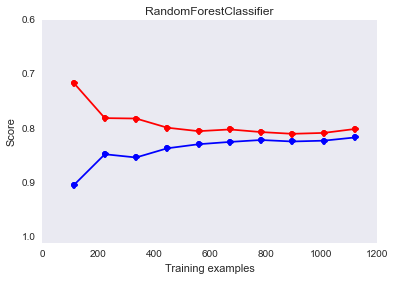

In [346]:
learning_curve_plot(clf,X_train,y_train)

###GridSearch Gradient Boosting Randomized

In [347]:
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import random

In [348]:
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


# specify parameters and distributions to sample from
param_dist = {
            "loss" : ['deviance','exponential'],
            "learning_rate" : [.01,.15,.2,.25,.3,.35,.4],
            "n_estimators" : sp_randint(100,300),
            "max_depth": [3,5,7, None],
            "max_features": sp_randint(2, 11),
            "min_samples_split": sp_randint(2, 11),
            "min_samples_leaf": sp_randint(2, 11)
           # "bootstrap": [True, False],
            }

In [354]:
start = time()
niters = 100
gbclf = GradientBoostingClassifier()
random_search = RandomizedSearchCV(gbclf, 
                                   param_distributions=param_dist,
                                   n_iter=niters)
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), niters))
report(random_search.grid_scores_)

RandomizedSearchCV took 91.71 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.819 (std: 0.023)
Parameters: {'loss': 'deviance', 'learning_rate': 0.01, 'min_samples_leaf': 6, 'n_estimators': 275, 'min_samples_split': 8, 'max_features': 9, 'max_depth': 7}

Model with rank: 2
Mean validation score: 0.816 (std: 0.014)
Parameters: {'loss': 'exponential', 'learning_rate': 0.01, 'min_samples_leaf': 10, 'n_estimators': 234, 'min_samples_split': 5, 'max_features': 10, 'max_depth': 5}

Model with rank: 3
Mean validation score: 0.815 (std: 0.024)
Parameters: {'loss': 'deviance', 'learning_rate': 0.01, 'min_samples_leaf': 10, 'n_estimators': 230, 'min_samples_split': 3, 'max_features': 7, 'max_depth': None}



In [355]:
gbclf1 = GradientBoostingClassifier(loss = 'deviance', min_samples_leaf = 6, n_estimators = 275, 
                                    min_samples_split = 6, max_features = 9, max_depth = 7, learning_rate = .01)

In [356]:
gbclf1.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=7, max_features=9, max_leaf_nodes=None,
              min_samples_leaf=6, min_samples_split=6,
              min_weight_fraction_leaf=0.0, n_estimators=275,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [357]:
predictgbClf = gbclf1.predict_proba(X_train)[:,1:]
print metrics.roc_auc_score(y_train,predictgbClf)

0.968622405884


In [358]:
predictgbClftest = gbclf1.predict_proba(X_test)[:,1:]
print metrics. roc_auc_score(y_test, predictgbClftest)

0.855667372881


In [359]:
predictGb1Testsub = gbclf1.predict_proba(X_submit)[:,1:]

dftocsv(rawTestNew,predictGb1Testsub,model = 'gb_BoW_RandGrid')

Saving Submission_gb_BoW_RandGrid.csv


In [360]:
#Scores 0.86308 on Test, Shoulda used this

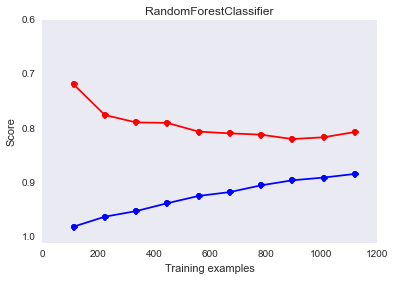

In [361]:
learning_curve_plot(gbclf1,X_train,y_train)

####To further improve model, need to do Clustering on BoW
####Reduce Features in model, then reapply glm/RF/CART/GradientBoosting 
####to each of the clusters and merge together based on the best model for each cluster